In [5]:
!pip install mlxtend --user
!pip install lightgbm --user
!pip install xgboost --user
!pip install plotly --user

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy as sp
import math
import seaborn as sn
import plotly.express as px
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
import warnings
warnings.filterwarnings('ignore')

# Model Performance Metric Functions

In [2]:
def rmse(y, y_pred):
    return np.sqrt(np.mean((y - y_pred)**2))

def mae(y, y_pred):
    return np.mean(np.absolute(np.subtract(y, y_pred)))

def r2(y, y_pred):
    return 1 - np.sum((y - y_pred)**2)/np.sum((y - np.mean(y))**2)

def mape(y, y_pred):
    return (np.mean(np.divide(np.absolute(np.subtract(y,y_pred)), y))*100)

def errors(y, y_pred):
    return np.absolute(y - y_pred)

# Model Building Function

In [9]:
def build_models(dataset, outlier_removal_lower_percentile, seed):
    #filter outliers
    dataset = dataset[(dataset['Yield_kg_per_Ha'] > dataset['Yield_kg_per_Ha'].quantile(outlier_removal_lower_percentile)) \
                                                                   & (dataset['Yield_kg_per_Ha'] < dataset['Yield_kg_per_Ha'].quantile(1-outlier_removal_lower_percentile))].reset_index(drop = True)

    #train/test split
    train_Yield_kg_per_ha, test_Yield_kg_per_ha = train_test_split(dataset, test_size = 0.2, random_state = seed)

    #x values
    X_train_Yield_kg_per_ha = train_Yield_kg_per_ha.drop(columns = ['Yield_kg_per_Ha'])
    X_test_Yield_kg_per_ha = test_Yield_kg_per_ha.drop(columns = ['Yield_kg_per_Ha'])
    standard_scaler_X = StandardScaler().fit(X_train_Yield_kg_per_ha)
    X_train_Yield_kg_per_ha = standard_scaler_X.transform(X_train_Yield_kg_per_ha)
    power_transform_X = PowerTransformer(standardize = True).fit(X_train_Yield_kg_per_ha)
    X_train_Yield_kg_per_ha = power_transform_X.transform(X_train_Yield_kg_per_ha)
    X_test_Yield_kg_per_ha = standard_scaler_X.transform(X_test_Yield_kg_per_ha)
    X_test_Yield_kg_per_ha = power_transform_X.transform(X_test_Yield_kg_per_ha)

    #y_values
    y_train_Yield_kg_per_ha = np.array(train_Yield_kg_per_ha['Yield_kg_per_Ha']).reshape(-1, 1)
    mean_Yield_kg_per_ha = y_train_Yield_kg_per_ha.mean()
    y_test_Yield_kg_per_ha = np.array(test_Yield_kg_per_ha['Yield_kg_per_Ha']).reshape(-1, 1)
    standard_scaler_y = StandardScaler().fit(np.array(y_train_Yield_kg_per_ha))
    y_train_Yield_kg_per_ha = standard_scaler_y.transform(y_train_Yield_kg_per_ha)
    power_transform_y = PowerTransformer(standardize = False).fit(y_train_Yield_kg_per_ha)
    y_train_Yield_kg_per_ha = power_transform_y.transform(y_train_Yield_kg_per_ha)
    y_test_Yield_kg_per_ha = standard_scaler_y.transform(y_test_Yield_kg_per_ha)
    y_test_Yield_kg_per_ha = power_transform_y.transform(y_test_Yield_kg_per_ha)

    ####Initialize K fold Cross validation
    kfolds = KFold(n_splits = 10, shuffle = True, random_state = 42)

    #####Grid Space for Lasso, Ridge, ElasticNet
    alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
    alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
    e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
    e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

    ####Model Building
#     model_names = ['OLS', 'Lasso', 'Ridge', 'ElasticNet', 'SVR', 'Lightgbm', 'GBR', 'XGBoost']
    model_names = ['OLS', 'Lasso', 'Ridge', 'ElasticNet', 'SVR', 'GBR', 'XGBoost']
    models = [linear_model.LinearRegression(), \
                LassoCV(max_iter = int(1e7), alphas = alphas2, random_state = 42, cv = kfolds), \
                      RidgeCV(alphas = alphas_alt, cv = kfolds), \
                      ElasticNetCV(max_iter = int(1e7), alphas = e_alphas, cv = kfolds, l1_ratio = e_l1ratio), \
                      SVR(C = 20, epsilon = 0.008, gamma = 0.0003), \
#                       LGBMRegressor(objective='regression', num_leaves = 4, learning_rate = 0.01, n_estimators = 5000, max_bin = 200, bagging_fraction = 0.75, \
#                                     bagging_freq = 5, bagging_seed = 7, feature_fraction = 0.2, feature_fraction_seed = 7, verbose = -1), \
                      GradientBoostingRegressor(n_estimators = 5000, learning_rate = 0.05, max_depth = 4, max_features = 'sqrt', min_samples_leaf = 15, \
                                                min_samples_split = 10, loss = 'huber', random_state = 42), \
                      XGBRegressor(learning_rate = 0.005, n_estimators = 10000, max_depth = 3, min_child_weight = 0, gamma = 0, subsample = 0.7, \
                                   colsample_bytree = 0.7, objective = 'reg:linear', nthread = -1, scale_pos_weight = 1, seed = 27, reg_alpha = 0.00006)
             ]

    fitted_models = []
    Test_MAE_models = []
    Test_RMSE_models = []
    Test_R2_models = []
    Test_mape_models = []

    for model in models:
        fitted_models.append(model.fit(X_train_Yield_kg_per_ha, y_train_Yield_kg_per_ha))
        inv_transform_y_actuals = standard_scaler_y.inverse_transform(power_transform_y.inverse_transform(y_test_Yield_kg_per_ha).reshape(-1, 1))
        inv_transformed_preds = standard_scaler_y.inverse_transform(power_transform_y.inverse_transform(fitted_models[models.index(model)].predict(X_test_Yield_kg_per_ha).reshape(-1,1)))                                             
        Test_MAE_models.append(mae(inv_transform_y_actuals, inv_transformed_preds))
        Test_RMSE_models.append(rmse(inv_transform_y_actuals, inv_transformed_preds))
        Test_R2_models.append(r2(inv_transform_y_actuals, inv_transformed_preds))
        Test_mape_models.append(mape(inv_transform_y_actuals, inv_transformed_preds))

    for model_name in model_names:
        print(model_name)
        print('MAE on test data: ' + str(Test_MAE_models[model_names.index(model_name)]))
        print('RMSE on test data: ' + str(Test_RMSE_models[model_names.index(model_name)]))
        print('R squared on test data: ' + str(Test_R2_models[model_names.index(model_name)]))
        print('MAPE on test data: ' + str(Test_mape_models[model_names.index(model_name)]))
        inv_transformed_y_actuals = standard_scaler_y.inverse_transform(power_transform_y.inverse_transform(y_test_Yield_kg_per_ha).reshape(-1, 1))
        inv_transformed_preds = standard_scaler_y.inverse_transform(power_transform_y.inverse_transform(fitted_models[model_names.index(model_name)].predict(X_test_Yield_kg_per_ha).reshape(-1,1)))
        fig, ax = plt.subplots()
        ax.axhline(y=mean_Yield_kg_per_ha, color='r', linestyle='-', label = 'Mean Actual Target = ' + str(int(mean_Yield_kg_per_ha)))
        ax.scatter(inv_transformed_y_actuals, inv_transformed_preds)
        lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()]),
        ]
        ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
        plt.xlabel('Actual Target')
        plt.ylabel('Predicted Target')
        plt.title(model_name + ' (Target: Yield kg per ha)')
        plt.legend()
        plt.show()
    return Test_R2_models[6]

# Importing Datasets

In [4]:
df_summer_combined_parents = pd.read_csv('/mnt/Wet_yield_prediction/Organized_Work/Datasets/df_summer_combined_parents.csv').drop(columns = 'Unnamed: 0')

In [5]:
df_winter_combined_parents = pd.read_csv('/mnt/Wet_yield_prediction/Organized_Work/Datasets/df_winter_combined_parents.csv').drop(columns = 'Unnamed: 0')

In [6]:
df_dy_wy_ratio_summer_combined_parents = pd.read_csv('/mnt/Wet_yield_prediction/Organized_Work/Datasets/df_dy_wy_ratio_summer_combined_parents.csv').drop(columns = 'Unnamed: 0')

In [7]:
df_dy_wy_ratio_winter_combined_parents = pd.read_csv('/mnt/Wet_yield_prediction/Organized_Work/Datasets/df_dy_wy_ratio_winter_combined_parents.csv').drop(columns = 'Unnamed: 0')

## Model Building Dataset 1: Summer Combined Parents

[20:15:50] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1727.3977659771906
RMSE on test data: 2245.8693382789834
R squared on test data: -0.02562707031546796
MAPE on test data: 29.46416643116295


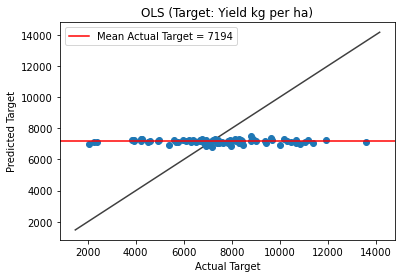

Lasso
MAE on test data: 1726.2585705663348
RMSE on test data: 2245.4682571463427
R squared on test data: -0.02526077746979727
MAPE on test data: 29.45067251476341


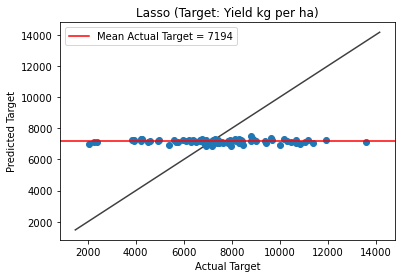

Ridge
MAE on test data: 1726.1539746894812
RMSE on test data: 2245.075034413428
R squared on test data: -0.02490172492600151
MAPE on test data: 29.451986041773264


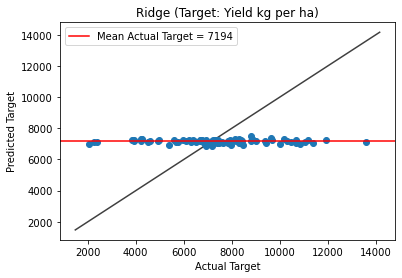

ElasticNet
MAE on test data: 1726.3675133653264
RMSE on test data: 2245.518867718655
R squared on test data: -0.025306994662416038
MAPE on test data: 29.45193335257868


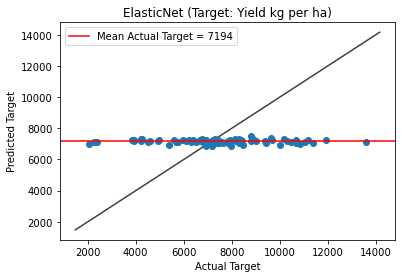

SVR
MAE on test data: 1711.3150865188193
RMSE on test data: 2229.9922243760493
R squared on test data: -0.01117704163858435
MAPE on test data: 29.321536833255113


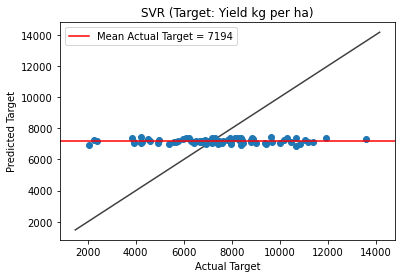

GBR
MAE on test data: 2025.3226746608736
RMSE on test data: 2523.5546459090715
R squared on test data: -0.29492891990793435
MAPE on test data: 32.42471453476578


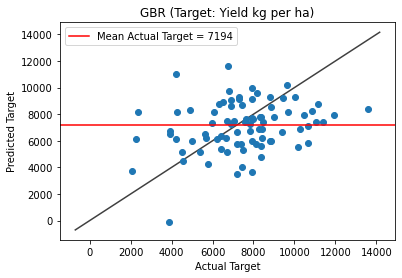

XGBoost
MAE on test data: 1816.7108279612207
RMSE on test data: 2236.069007218915
R squared on test data: -0.01669551427104854
MAPE on test data: 28.35916018700228


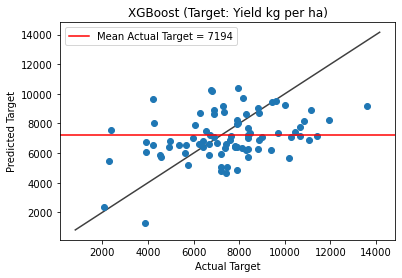

[20:16:14] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1776.4853197966897
RMSE on test data: 2266.87126657005
R squared on test data: -0.06968678261307804
MAPE on test data: 35.32240988044367


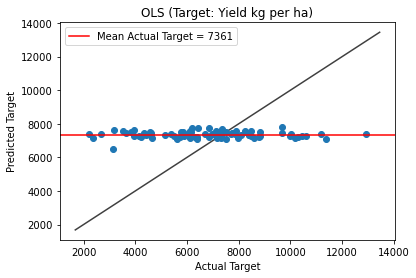

Lasso
MAE on test data: 1776.4382243466873
RMSE on test data: 2266.351779243392
R squared on test data: -0.0691965694606338
MAPE on test data: 35.3197949698023


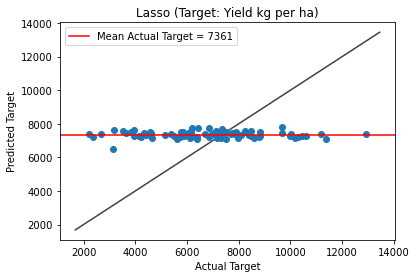

Ridge
MAE on test data: 1776.2479812083727
RMSE on test data: 2266.233708410422
R squared on test data: -0.06908516783065344
MAPE on test data: 35.32299800735277


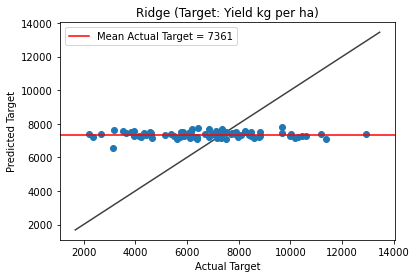

ElasticNet
MAE on test data: 1776.4440912931632
RMSE on test data: 2266.4161433272675
R squared on test data: -0.06925730039880085
MAPE on test data: 35.32012171167691


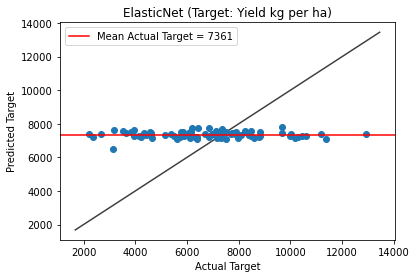

SVR
MAE on test data: 1805.253952229552
RMSE on test data: 2297.165751828279
R squared on test data: -0.09846843013156459
MAPE on test data: 35.94599513637915


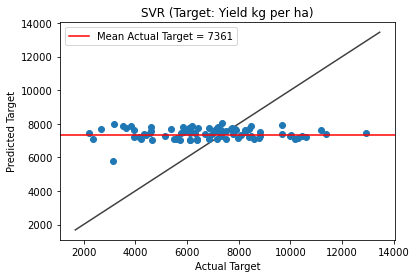

GBR
MAE on test data: 1798.9903809335622
RMSE on test data: 2339.392958128977
R squared on test data: -0.13922438077163424
MAPE on test data: 33.54246061191412


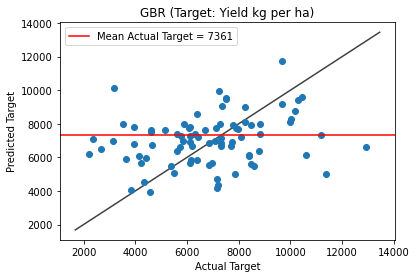

XGBoost
MAE on test data: 1737.0932700920443
RMSE on test data: 2260.886259180076
R squared on test data: -0.0640458518876037
MAPE on test data: 33.07510225780885


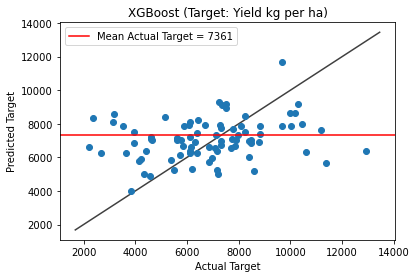

[20:16:37] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1386.9837443434214
RMSE on test data: 1692.843612014012
R squared on test data: -0.06098024783959288
MAPE on test data: 22.309618618032857


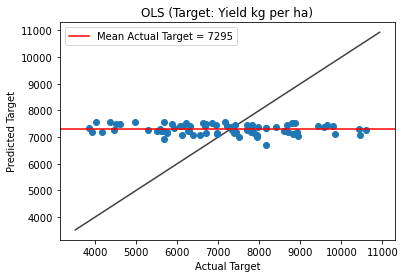

Lasso
MAE on test data: 1386.2411029125626
RMSE on test data: 1691.8391287523664
R squared on test data: -0.0597215128873807
MAPE on test data: 22.294645379896018


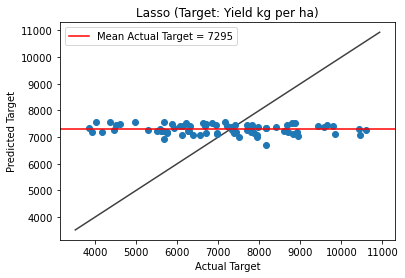

Ridge
MAE on test data: 1384.371186240035
RMSE on test data: 1689.9409520077365
R squared on test data: -0.057344915415625586
MAPE on test data: 22.2637396797192


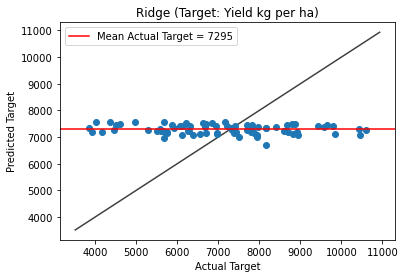

ElasticNet
MAE on test data: 1386.3339234123878
RMSE on test data: 1691.964331972561
R squared on test data: -0.05987836640037458
MAPE on test data: 22.296516916765206


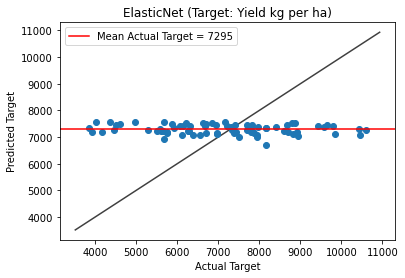

SVR
MAE on test data: 1390.7213593723845
RMSE on test data: 1698.904841807188
R squared on test data: -0.0685915332164928
MAPE on test data: 22.286747926304997


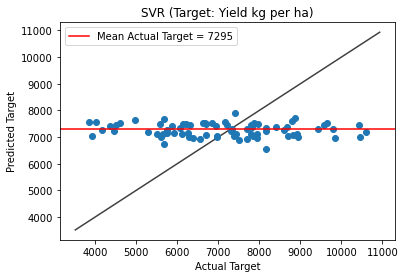

GBR
MAE on test data: 1523.9428288003764
RMSE on test data: 1962.0117312456891
R squared on test data: -0.42520330316652233
MAPE on test data: 24.04664305867726


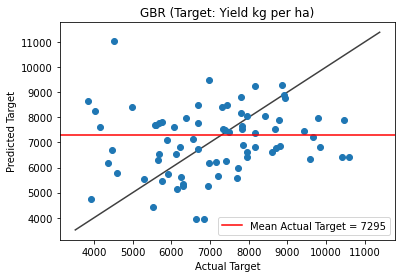

XGBoost
MAE on test data: 1502.5565322468638
RMSE on test data: 1960.285399897661
R squared on test data: -0.4226963959079555
MAPE on test data: 23.727614543286723


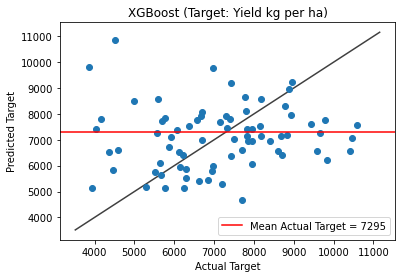

[20:16:59] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1480.841603110877
RMSE on test data: 1801.9422584157148
R squared on test data: -0.0857647390021905
MAPE on test data: 24.02534468165742


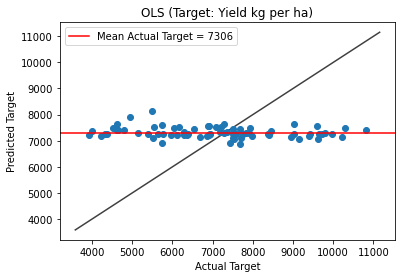

Lasso
MAE on test data: 1480.2873501269987
RMSE on test data: 1801.3833192555508
R squared on test data: -0.08509126313922799
MAPE on test data: 24.016046295331257


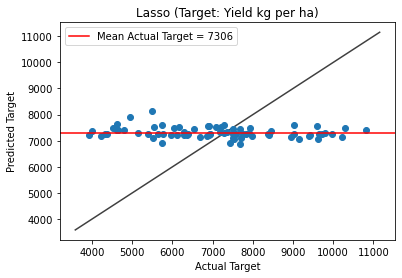

Ridge
MAE on test data: 1477.1060325786545
RMSE on test data: 1797.9458567700935
R squared on test data: -0.08095399635083411
MAPE on test data: 23.963355637278397


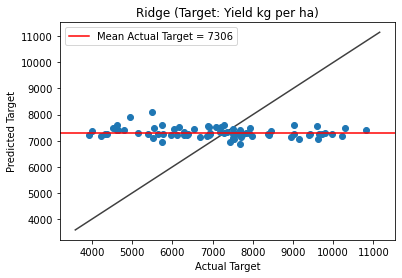

ElasticNet
MAE on test data: 1480.3566517194631
RMSE on test data: 1801.4529775579006
R squared on test data: -0.0851751842857158
MAPE on test data: 24.017208897497312


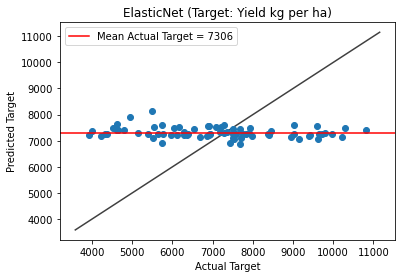

SVR
MAE on test data: 1500.4579787478672
RMSE on test data: 1827.8110625646812
R squared on test data: -0.117163134603256
MAPE on test data: 24.21255842367149


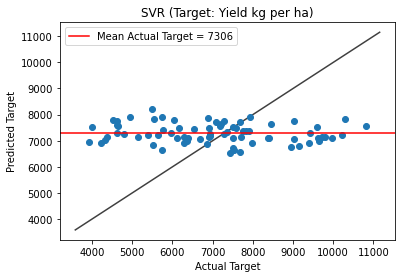

GBR
MAE on test data: 1601.9068881973296
RMSE on test data: 1904.3411568254976
R squared on test data: -0.21267241869016495
MAPE on test data: 24.326903050815137


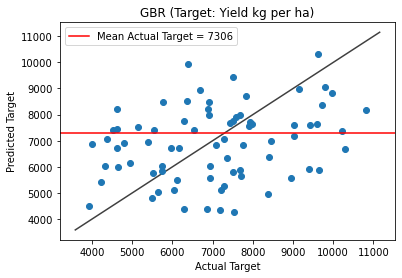

XGBoost
MAE on test data: 1588.8569732312415
RMSE on test data: 1864.7646545758741
R squared on test data: -0.16279204120325552
MAPE on test data: 24.65377681600798


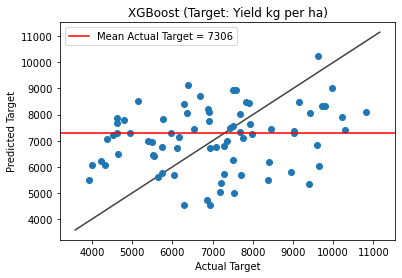

[20:17:21] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1089.7390192289806
RMSE on test data: 1326.0680679286188
R squared on test data: -0.025941567464968562
MAPE on test data: 16.541072904544514


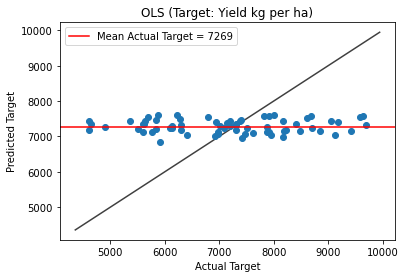

Lasso
MAE on test data: 1089.4414391526245
RMSE on test data: 1325.7680435957645
R squared on test data: -0.025477379206632067
MAPE on test data: 16.534539781435996


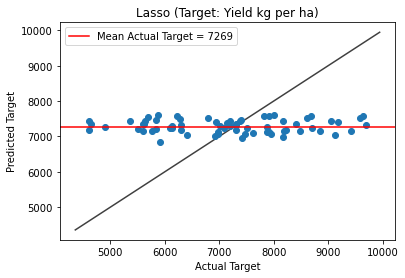

Ridge
MAE on test data: 1088.35439205616
RMSE on test data: 1324.645828553157
R squared on test data: -0.023742054406310942
MAPE on test data: 16.51574002286948


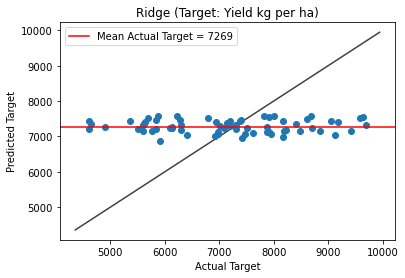

ElasticNet
MAE on test data: 1089.4786279577575
RMSE on test data: 1325.8050818967888
R squared on test data: -0.02553467802387721
MAPE on test data: 16.535356265193155


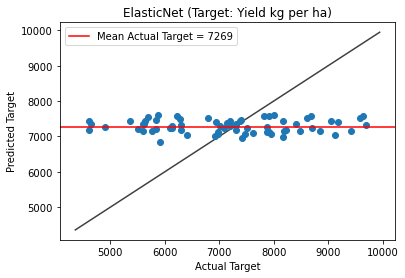

SVR
MAE on test data: 1075.3220133040659
RMSE on test data: 1301.4375401287828
R squared on test data: 0.011816378590157273
MAPE on test data: 16.19366323346492


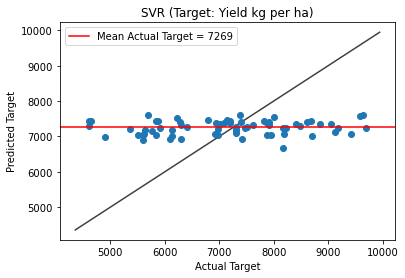

GBR
MAE on test data: 1194.7068266557299
RMSE on test data: 1513.3545841032499
R squared on test data: -0.33620282295093085
MAPE on test data: 18.17302583108938


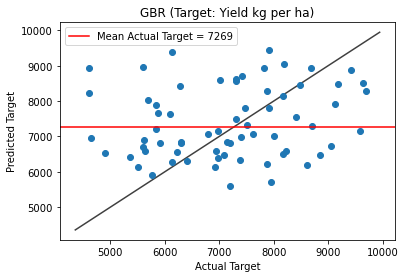

XGBoost
MAE on test data: 1227.6939372793786
RMSE on test data: 1448.6399640982659
R squared on test data: -0.22436784616309713
MAPE on test data: 18.468478518827474


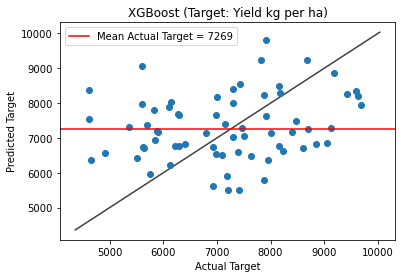

[20:17:43] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1221.2262083334037
RMSE on test data: 1470.0916583557816
R squared on test data: -0.02578845170997579
MAPE on test data: 17.76618628764189


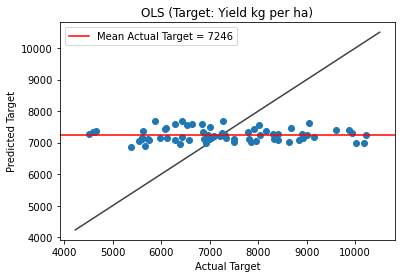

Lasso
MAE on test data: 1220.792739529882
RMSE on test data: 1469.5265834319957
R squared on test data: -0.02500001661446216
MAPE on test data: 17.76019967340943


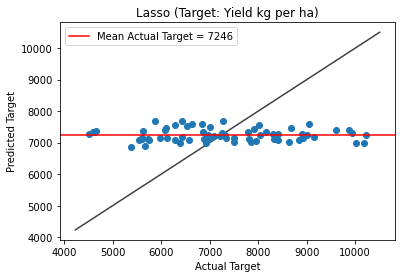

Ridge
MAE on test data: 1219.416696854994
RMSE on test data: 1467.5976226382343
R squared on test data: -0.02231086869292276
MAPE on test data: 17.743360945061408


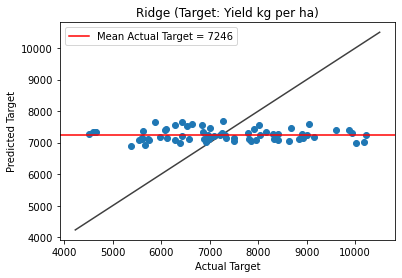

ElasticNet
MAE on test data: 1220.8469358776176
RMSE on test data: 1469.5968711107798
R squared on test data: -0.025098070771075953
MAPE on test data: 17.760948148567188


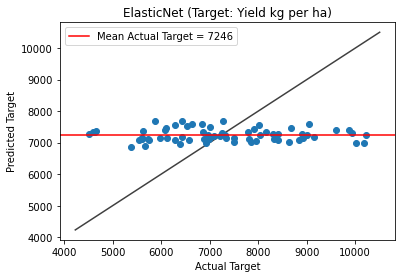

SVR
MAE on test data: 1217.225337372052
RMSE on test data: 1455.369506920762
R squared on test data: -0.005345923916985296
MAPE on test data: 17.929451389629218


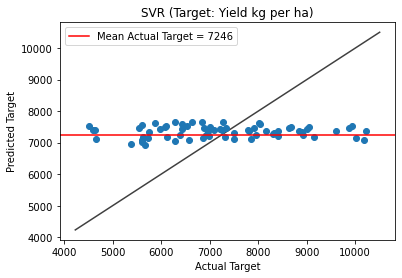

GBR
MAE on test data: 1377.9354360954135
RMSE on test data: 1643.8212007536915
R squared on test data: -0.28256130647461974
MAPE on test data: 19.89296386194144


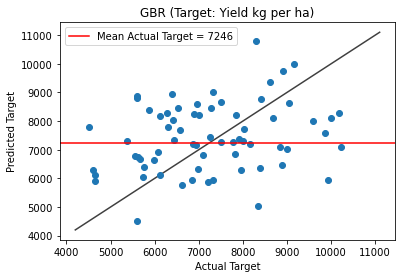

XGBoost
MAE on test data: 1325.1705533657391
RMSE on test data: 1605.4859010874466
R squared on test data: -0.22343801536824603
MAPE on test data: 19.271037637105913


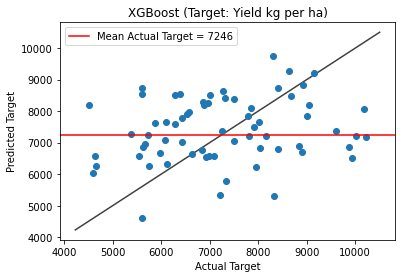

In [14]:
#set each equal to a variable and collect
build_models(df_summer_combined_parents, 0, 50)
build_models(df_summer_combined_parents, 0, 60)
build_models(df_summer_combined_parents, 0, 70)
build_models(df_summer_combined_parents, 0, 80)
build_models(df_summer_combined_parents, .05, 50)
build_models(df_summer_combined_parents, .05, 60)
build_models(df_summer_combined_parents, .05, 70)
build_models(df_summer_combined_parents, .05, 80)
build_models(df_summer_combined_parents, .1, 50)
build_models(df_summer_combined_parents, .1, 60)
build_models(df_summer_combined_parents, .1, 70)
build_models(df_summer_combined_parents, .1, 80)

## Model Building Dataset 2: Winter Combined Parents

[20:18:06] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1534.9163007607435
RMSE on test data: 1855.3690396169688
R squared on test data: -0.09764851244814232
MAPE on test data: 25.97976878694916


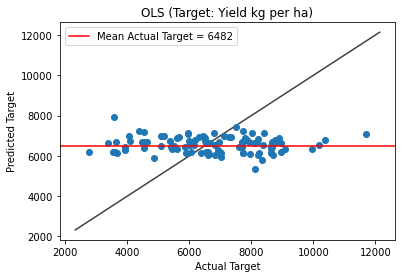

Lasso
MAE on test data: 1534.2834020204277
RMSE on test data: 1854.3032068831103
R squared on test data: -0.09638776738071253
MAPE on test data: 25.96910443422127


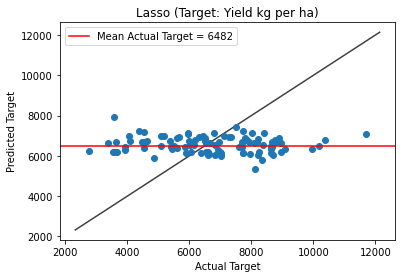

Ridge
MAE on test data: 1530.699143687276
RMSE on test data: 1849.9746422403875
R squared on test data: -0.09127506932690088
MAPE on test data: 25.91481521750486


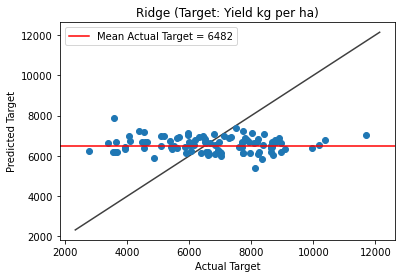

ElasticNet
MAE on test data: 1534.3626073190414
RMSE on test data: 1854.4359655209494
R squared on test data: -0.09654476452820826
MAPE on test data: 25.970439336552197


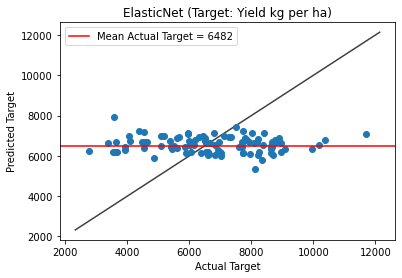

SVR
MAE on test data: 1508.0219120828383
RMSE on test data: 1834.689946581414
R squared on test data: -0.0733170911722969
MAPE on test data: 25.862764694056285


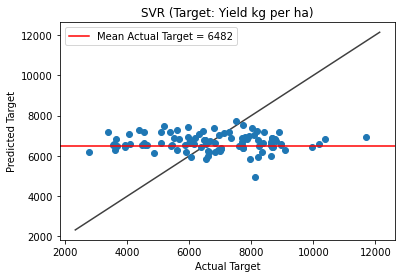

GBR
MAE on test data: 1323.299023001762
RMSE on test data: 1724.6102695526831
R squared on test data: 0.05161512679903535
MAPE on test data: 20.517281725573795


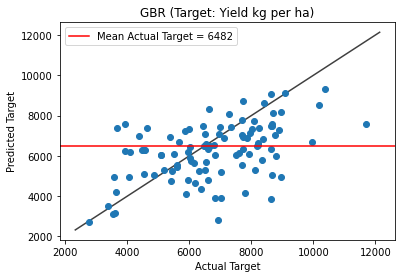

XGBoost
MAE on test data: 1307.1639851328382
RMSE on test data: 1670.8003813045516
R squared on test data: 0.10987332910766767
MAPE on test data: 21.21642431867022


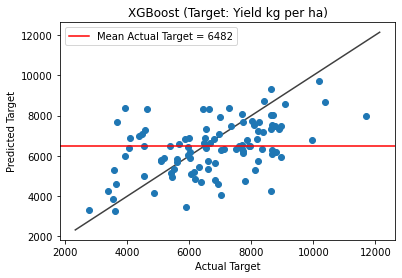

[20:18:29] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1726.8805526103185
RMSE on test data: 2144.2412978487464
R squared on test data: -0.12205224345120191
MAPE on test data: 33.693582651469725


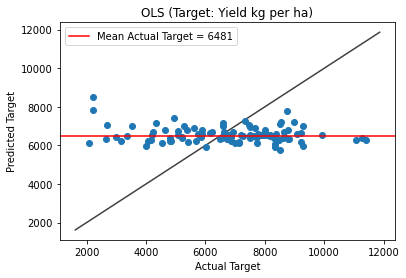

Lasso
MAE on test data: 1725.8824990566143
RMSE on test data: 2142.948144504502
R squared on test data: -0.12069927251380408
MAPE on test data: 33.673834273484054


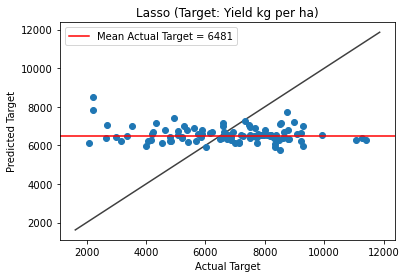

Ridge
MAE on test data: 1723.5675407423978
RMSE on test data: 2138.5143528987346
R squared on test data: -0.11606658307881879
MAPE on test data: 33.62052110776042


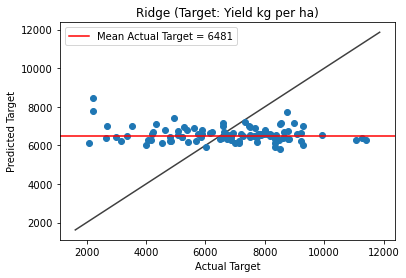

ElasticNet
MAE on test data: 1726.0072671373603
RMSE on test data: 2143.1094548207957
R squared on test data: -0.12086800002939913
MAPE on test data: 33.67630324848542


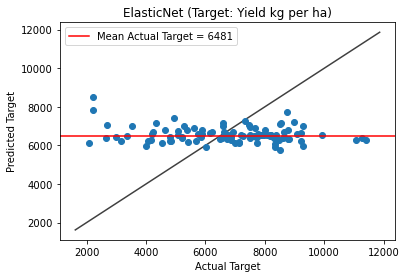

SVR
MAE on test data: 1664.6313827719614
RMSE on test data: 2110.318430720692
R squared on test data: -0.086830330271084
MAPE on test data: 33.370473917184576


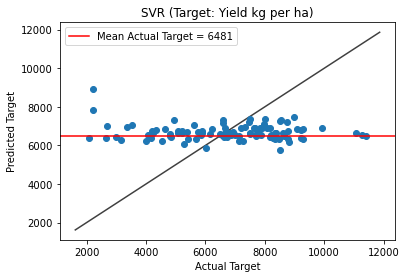

GBR
MAE on test data: 1551.0587469600116
RMSE on test data: 1985.8589939211163
R squared on test data: 0.03758455891320733
MAPE on test data: 27.1924997944648


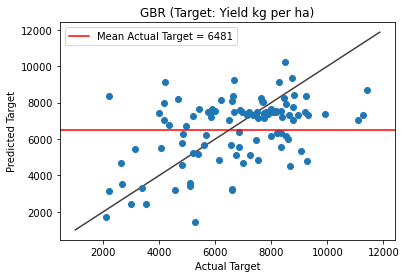

XGBoost
MAE on test data: 1505.965872896056
RMSE on test data: 1948.502871057969
R squared on test data: 0.07345212134881773
MAPE on test data: 27.157670086273335


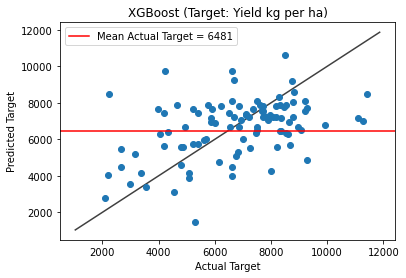

[20:18:52] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1518.2552839499351
RMSE on test data: 1839.1739226075115
R squared on test data: -0.10838748883181593
MAPE on test data: 30.4400246608002


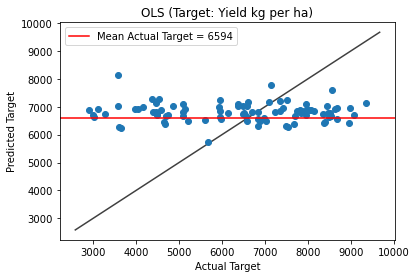

Lasso
MAE on test data: 1518.2257539212703
RMSE on test data: 1839.1228014278256
R squared on test data: -0.10832587281192807
MAPE on test data: 30.43938265581997


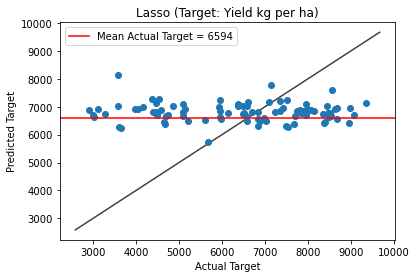

Ridge
MAE on test data: 1516.1175049215265
RMSE on test data: 1835.2939371540022
R squared on test data: -0.1037158359669248
MAPE on test data: 30.392249926318687


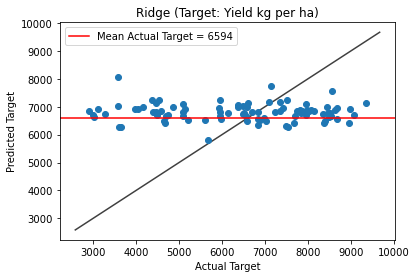

ElasticNet
MAE on test data: 1518.206945186716
RMSE on test data: 1839.0898939662943
R squared on test data: -0.10828621057219445
MAPE on test data: 30.438971777887268


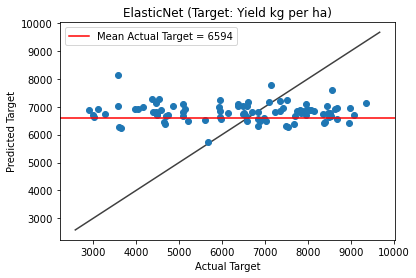

SVR
MAE on test data: 1505.5013928886312
RMSE on test data: 1831.4003031232126
R squared on test data: -0.09903766769324807
MAPE on test data: 30.419838950834


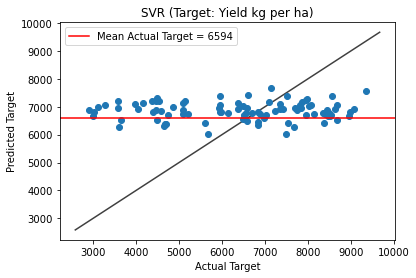

GBR
MAE on test data: 1211.5499704271058
RMSE on test data: 1674.4330414935991
R squared on test data: 0.08128335555924104
MAPE on test data: 22.347250449589005


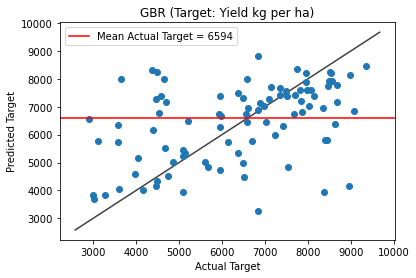

XGBoost
MAE on test data: 1281.3297994338716
RMSE on test data: 1658.9686475111116
R squared on test data: 0.09817479150531128
MAPE on test data: 24.103440033708836


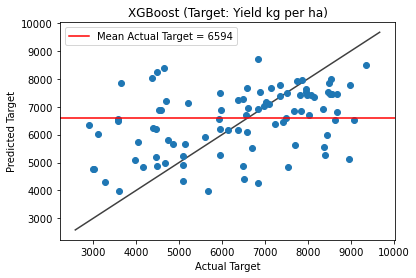

[20:19:15] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1478.0661526824183
RMSE on test data: 1757.4102470810083
R squared on test data: -0.0672436286031477
MAPE on test data: 26.237599746527078


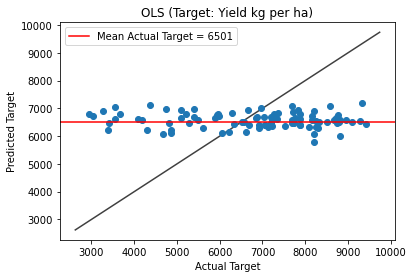

Lasso
MAE on test data: 1477.352977843808
RMSE on test data: 1756.4509687175614
R squared on test data: -0.06607884160120059
MAPE on test data: 26.22614863010377


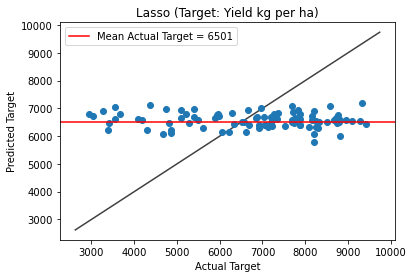

Ridge
MAE on test data: 1475.1200863491647
RMSE on test data: 1754.0403968685243
R squared on test data: -0.06315465386251051
MAPE on test data: 26.198389338330898


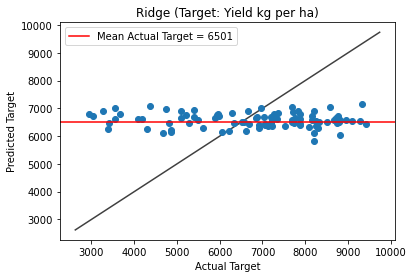

ElasticNet
MAE on test data: 1477.442024750171
RMSE on test data: 1756.5705225830675
R squared on test data: -0.06622397310367689
MAPE on test data: 26.227578172872263


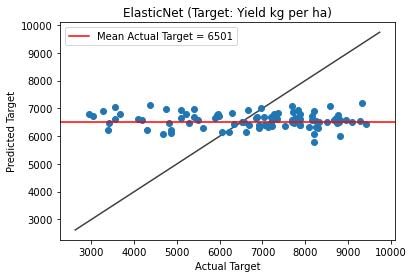

SVR
MAE on test data: 1478.5571629051426
RMSE on test data: 1775.7290100823004
R squared on test data: -0.08960889942250239
MAPE on test data: 26.43242147586657


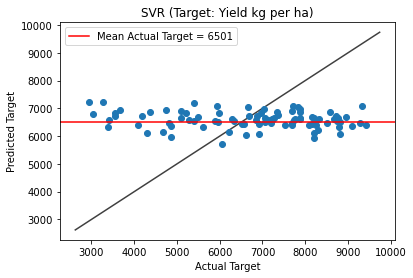

GBR
MAE on test data: 1397.3747335642327
RMSE on test data: 1898.553810002225
R squared on test data: -0.24555549906231544
MAPE on test data: 22.58748784358168


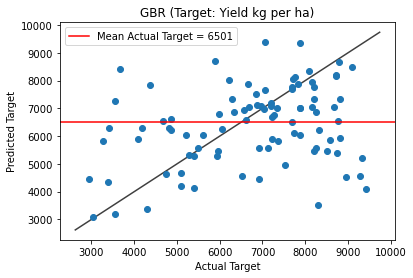

XGBoost
MAE on test data: 1261.9011985154468
RMSE on test data: 1724.3852599766162
R squared on test data: -0.02750954700645547
MAPE on test data: 20.27991798408704


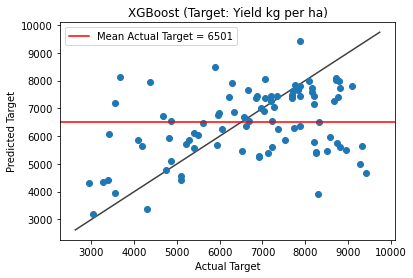

[20:19:38] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1251.4503474503538
RMSE on test data: 1521.2996840085264
R squared on test data: -0.057376056119610386
MAPE on test data: 22.17596535038668


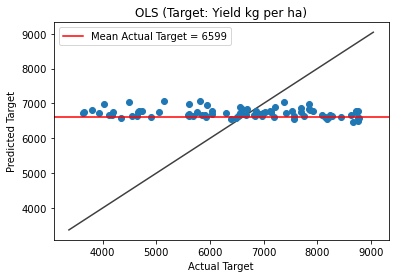

Lasso
MAE on test data: 1251.3164850764463
RMSE on test data: 1520.873817603725
R squared on test data: -0.05678414393218989
MAPE on test data: 22.173721107755135


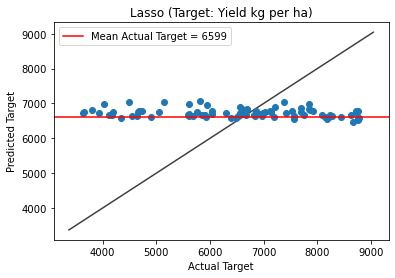

Ridge
MAE on test data: 1250.7876224014947
RMSE on test data: 1520.115385484809
R squared on test data: -0.05573040866270662
MAPE on test data: 22.166577294659483


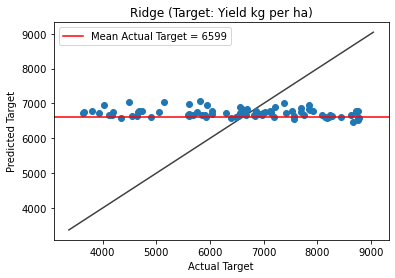

ElasticNet
MAE on test data: 1251.3331952221968
RMSE on test data: 1520.926809687708
R squared on test data: -0.05685778866075153
MAPE on test data: 22.174001508743416


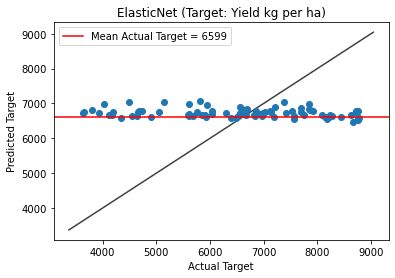

SVR
MAE on test data: 1268.6042953293268
RMSE on test data: 1556.0053459691253
R squared on test data: -0.10617054809489712
MAPE on test data: 22.54256526208553


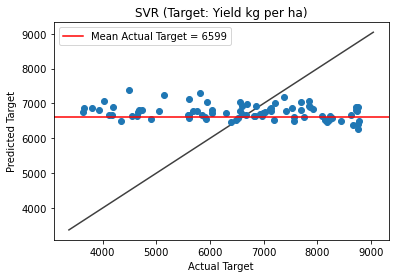

GBR
MAE on test data: 1256.3914599974673
RMSE on test data: 1668.943297491751
R squared on test data: -0.27257411482728977
MAPE on test data: 22.037761072960663


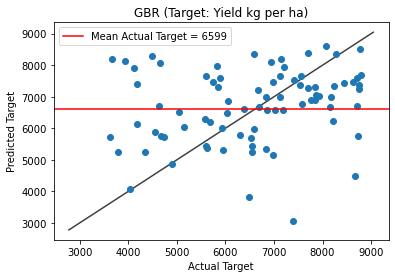

XGBoost
MAE on test data: 1195.9118820012613
RMSE on test data: 1594.6073880543915
R squared on test data: -0.16173604794651797
MAPE on test data: 21.22458401434311


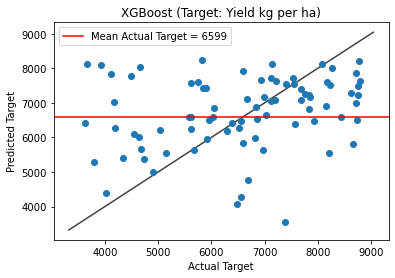

[20:20:01] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1315.9867348502119
RMSE on test data: 1543.5595430225114
R squared on test data: -0.13636579637164492
MAPE on test data: 23.400838384866546


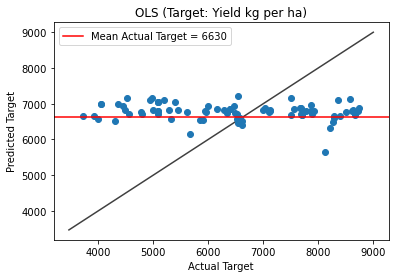

Lasso
MAE on test data: 1315.6993169235182
RMSE on test data: 1542.9413107889109
R squared on test data: -0.13545569572008453
MAPE on test data: 23.394819655367534


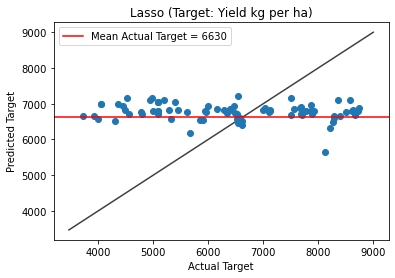

Ridge
MAE on test data: 1313.5113208857272
RMSE on test data: 1539.423596364264
R squared on test data: -0.13028420189647427
MAPE on test data: 23.359512744260115


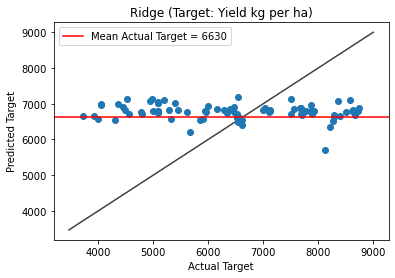

ElasticNet
MAE on test data: 1315.7352277205619
RMSE on test data: 1543.0182176556168
R squared on test data: -0.13556889058438948
MAPE on test data: 23.395572255261182


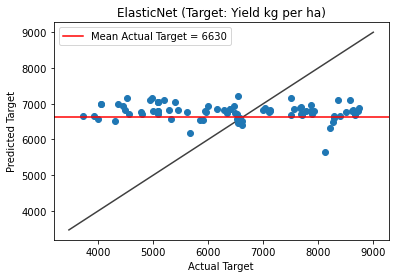

SVR
MAE on test data: 1323.6518812252505
RMSE on test data: 1563.1829643156366
R squared on test data: -0.16544291488126395
MAPE on test data: 23.615205267745836


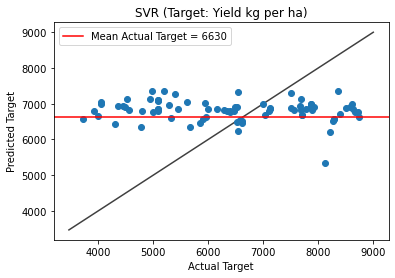

GBR
MAE on test data: 1180.6390356218194
RMSE on test data: 1502.729649321336
R squared on test data: -0.0770431170117003
MAPE on test data: 20.24735099596625


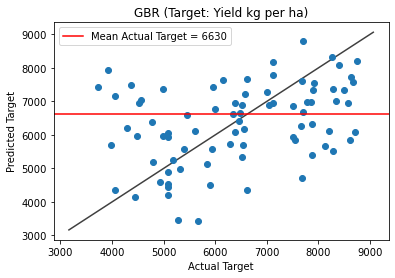

XGBoost
MAE on test data: 1122.3109477747626
RMSE on test data: 1422.235103379328
R squared on test data: 0.03525137918729415
MAPE on test data: 19.21434394328584


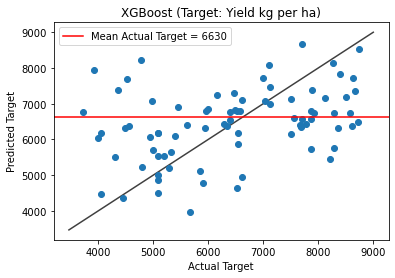

In [15]:
build_models(df_winter_combined_parents, 0, 50)
build_models(df_winter_combined_parents, 0, 60)
build_models(df_winter_combined_parents, 0, 70)
build_models(df_winter_combined_parents, 0, 80)
build_models(df_winter_combined_parents, .05, 50)
build_models(df_winter_combined_parents, .05, 60)
build_models(df_winter_combined_parents, .05, 70)
build_models(df_winter_combined_parents, .05, 80)
build_models(df_winter_combined_parents, .1, 50)
build_models(df_winter_combined_parents, .1, 60)
build_models(df_winter_combined_parents, .1, 70)
build_models(df_winter_combined_parents, .1, 80)

## Model Building Dataset 3: Summer Acceptable DY/WY Ratio Combined Parents

[20:20:25] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1521.1837469327916
RMSE on test data: 1988.6719370177834
R squared on test data: -0.01618970679931553
MAPE on test data: 23.830600335737984


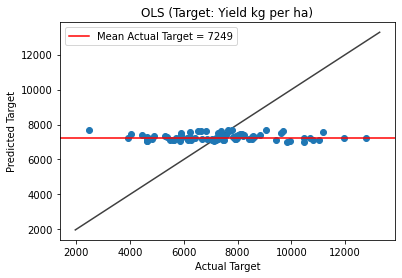

Lasso
MAE on test data: 1520.995385705875
RMSE on test data: 1987.8573729108273
R squared on test data: -0.015357410510297154
MAPE on test data: 23.82801652752861


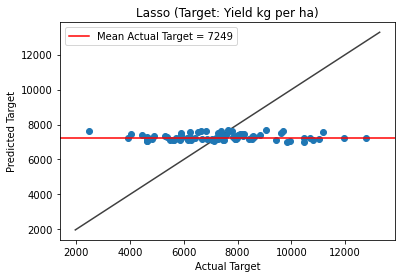

Ridge
MAE on test data: 1520.5078700946135
RMSE on test data: 1987.0290034961413
R squared on test data: -0.014511358084405401
MAPE on test data: 23.814752713796242


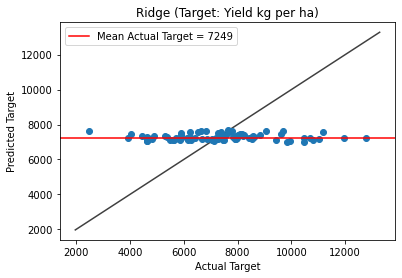

ElasticNet
MAE on test data: 1521.0189557942165
RMSE on test data: 1987.9585900574307
R squared on test data: -0.015460812492473552
MAPE on test data: 23.828339755340178


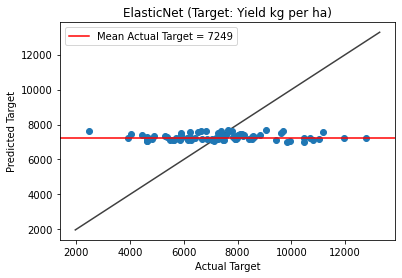

SVR
MAE on test data: 1552.4738569797742
RMSE on test data: 1964.3792454294805
R squared on test data: 0.00848525988635862
MAPE on test data: 24.425199380349348


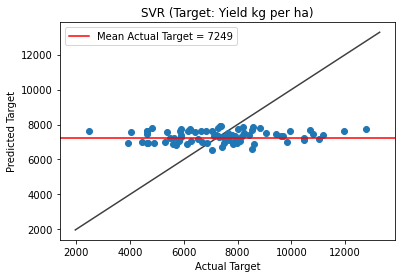

GBR
MAE on test data: 1743.679211209427
RMSE on test data: 2316.064808746578
R squared on test data: -0.37831955106389925
MAPE on test data: 25.39906081525555


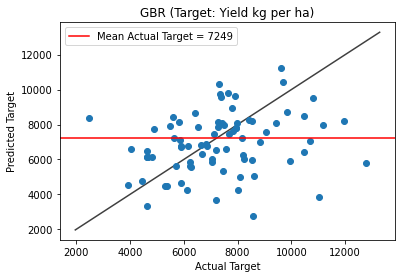

XGBoost
MAE on test data: 1527.512097209307
RMSE on test data: 2032.7664635736437
R squared on test data: -0.06175294747454263
MAPE on test data: 22.428556082095437


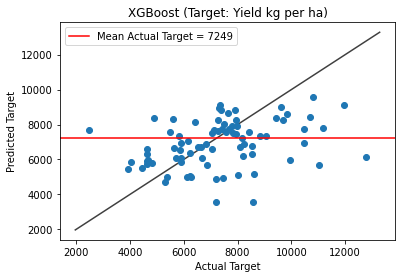

[20:20:48] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1769.403284622153
RMSE on test data: 2199.7231541064793
R squared on test data: -0.07337152284900617
MAPE on test data: 35.292018911535976


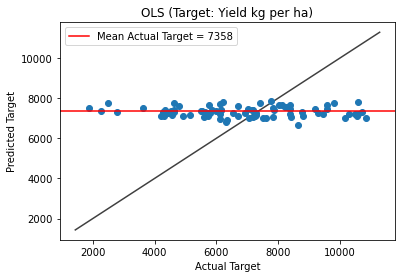

Lasso
MAE on test data: 1768.7581174641368
RMSE on test data: 2199.0293414860334
R squared on test data: -0.07269452741703608
MAPE on test data: 35.27862076318767


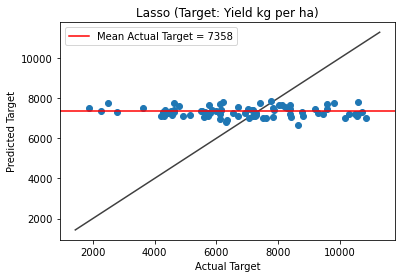

Ridge
MAE on test data: 1768.6578092974337
RMSE on test data: 2198.6088384266145
R squared on test data: -0.07228432079115521
MAPE on test data: 35.28174200051311


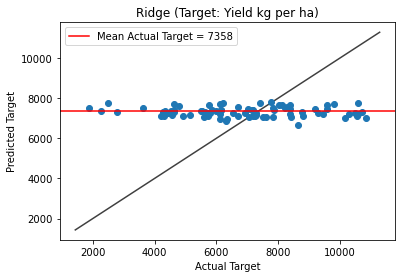

ElasticNet
MAE on test data: 1768.8387563291217
RMSE on test data: 2199.1157397957327
R squared on test data: -0.072778819893621
MAPE on test data: 35.280295391991906


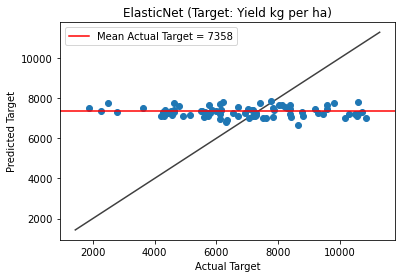

SVR
MAE on test data: 1791.1773010369332
RMSE on test data: 2234.1439373040926
R squared on test data: -0.10722610323053305
MAPE on test data: 35.76497584771023


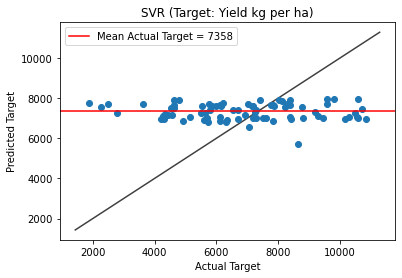

GBR
MAE on test data: 1781.108220134846
RMSE on test data: 2128.6903938260207
R squared on test data: -0.005168840446799772
MAPE on test data: 32.42460238867852


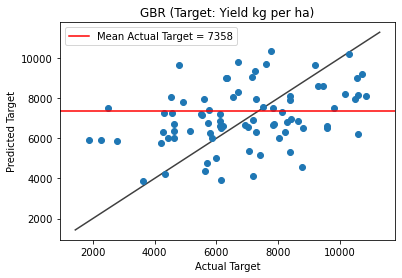

XGBoost
MAE on test data: 1847.0881279560854
RMSE on test data: 2139.2971799981515
R squared on test data: -0.015210858013110506
MAPE on test data: 34.23599541263162


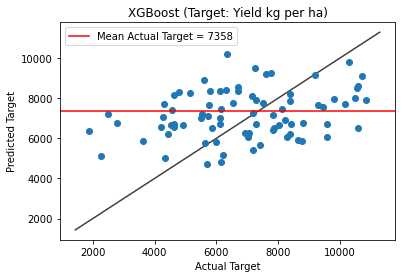

[20:21:10] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1562.4108576340525
RMSE on test data: 1887.0149236225984
R squared on test data: -0.010070452546455
MAPE on test data: 23.656499474284693


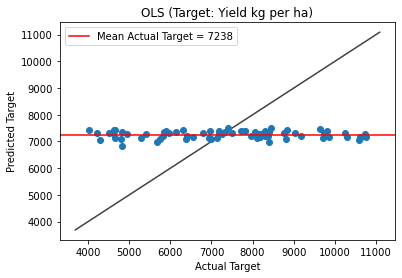

Lasso
MAE on test data: 1562.4953651223307
RMSE on test data: 1886.855459623569
R squared on test data: -0.009899745822341321
MAPE on test data: 23.656693731489252


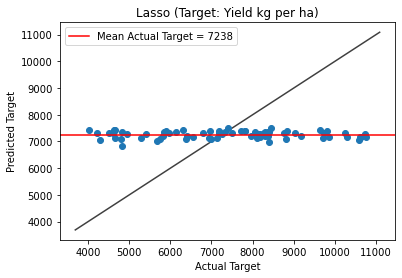

Ridge
MAE on test data: 1561.9882162052297
RMSE on test data: 1886.4520890683382
R squared on test data: -0.009468000744937255
MAPE on test data: 23.647005027197128


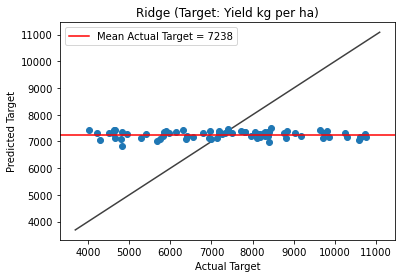

ElasticNet
MAE on test data: 1562.4848030964433
RMSE on test data: 1886.8751955018238
R squared on test data: -0.009920872361280475
MAPE on test data: 23.65666947537943


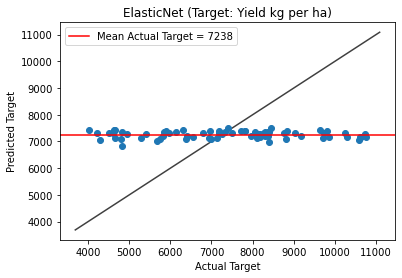

SVR
MAE on test data: 1556.7868682444216
RMSE on test data: 1899.0787628683288
R squared on test data: -0.02302666005323717
MAPE on test data: 23.603906589753322


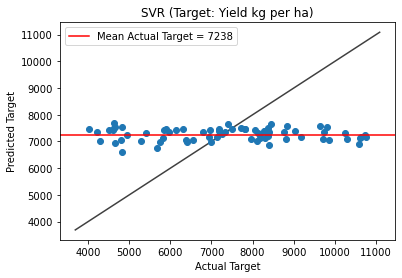

GBR
MAE on test data: 1455.416561295967
RMSE on test data: 1790.4307261221725
R squared on test data: 0.0906814685443782
MAPE on test data: 21.953819439708123


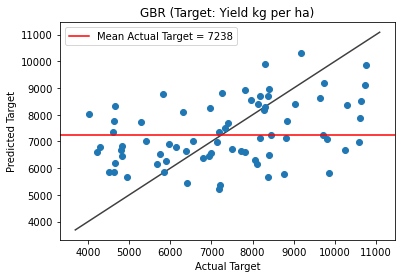

XGBoost
MAE on test data: 1470.973011158607
RMSE on test data: 1811.3929154613136
R squared on test data: 0.06926439731718204
MAPE on test data: 22.091388286569487


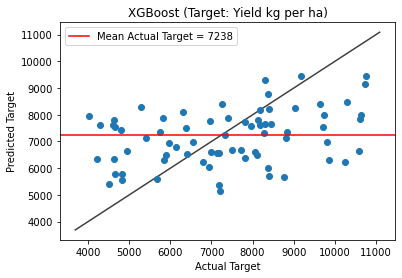

[20:21:33] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1332.7713255976912
RMSE on test data: 1619.9652331151071
R squared on test data: -0.016796395291186927
MAPE on test data: 20.682126071185237


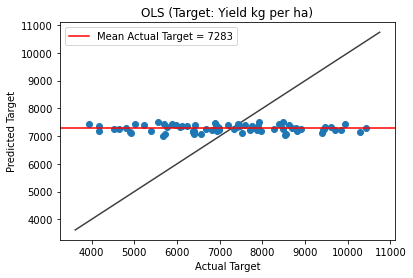

Lasso
MAE on test data: 1332.7924904845104
RMSE on test data: 1619.8793158179126
R squared on test data: -0.016688543493321495
MAPE on test data: 20.682717612759426


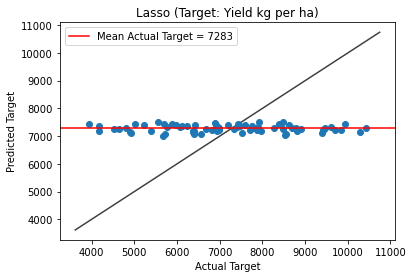

Ridge
MAE on test data: 1332.4835294282177
RMSE on test data: 1619.0793618505227
R squared on test data: -0.015684637576613314
MAPE on test data: 20.67515062083092


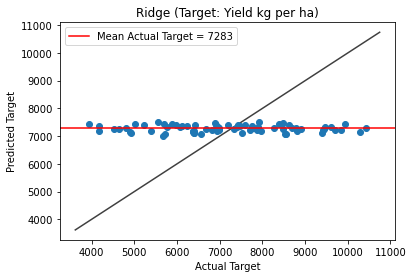

ElasticNet
MAE on test data: 1332.7898482110463
RMSE on test data: 1619.8898460394664
R squared on test data: -0.016701761750147703
MAPE on test data: 20.68264376955614


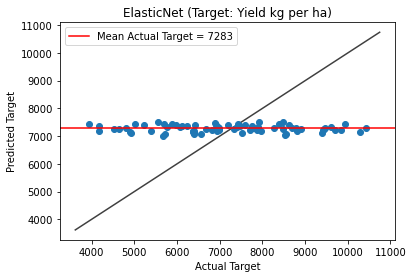

SVR
MAE on test data: 1328.0796129975733
RMSE on test data: 1618.624156996849
R squared on test data: -0.015113597523196187
MAPE on test data: 20.638639358236034


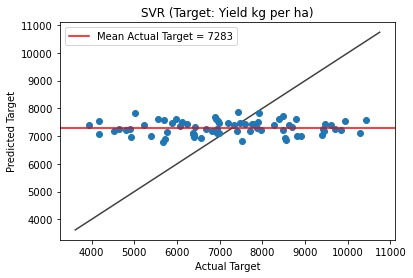

GBR
MAE on test data: 1672.080076961331
RMSE on test data: 2067.371399985915
R squared on test data: -0.6559972747615499
MAPE on test data: 25.27847457540171


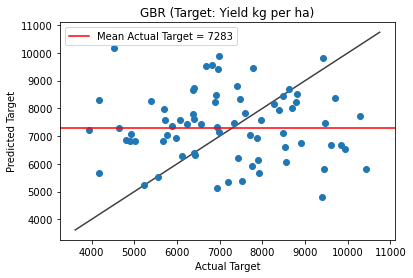

XGBoost
MAE on test data: 1533.8102541917774
RMSE on test data: 1943.6048736760715
R squared on test data: -0.4636544876524704
MAPE on test data: 22.99517302367574


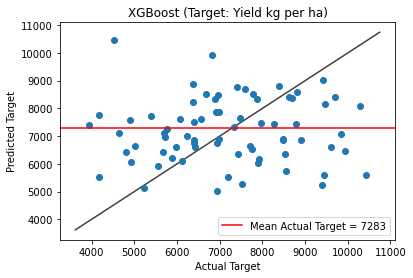

[20:21:56] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1081.5529790155113
RMSE on test data: 1312.3499829060215
R squared on test data: -0.034059908271997674
MAPE on test data: 15.43296640338613


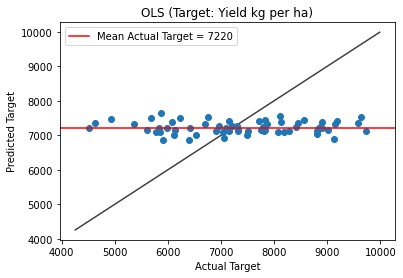

Lasso
MAE on test data: 1081.5892093153209
RMSE on test data: 1312.1026115742256
R squared on test data: -0.03367011489096594
MAPE on test data: 15.432709484888601


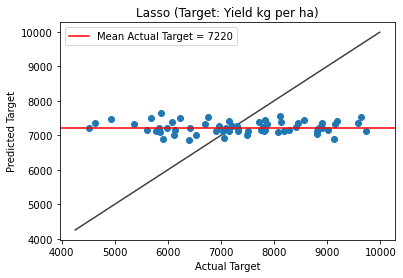

Ridge
MAE on test data: 1081.61894439864
RMSE on test data: 1311.3495908166137
R squared on test data: -0.03248400080210301
MAPE on test data: 15.427164744390911


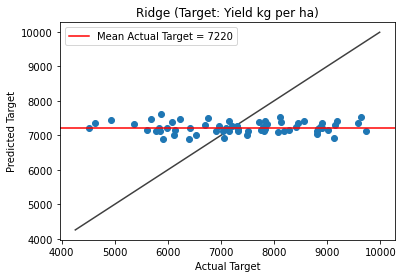

ElasticNet
MAE on test data: 1081.5846777665647
RMSE on test data: 1312.1332475488653
R squared on test data: -0.033718385294278175
MAPE on test data: 15.432741547650256


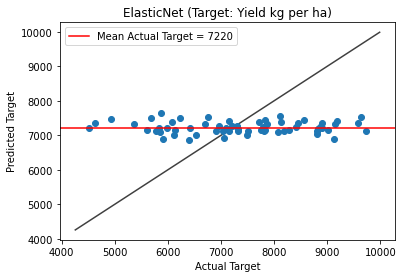

SVR
MAE on test data: 1101.753794372211
RMSE on test data: 1326.660836680572
R squared on test data: -0.05673521004023052
MAPE on test data: 15.680859415604399


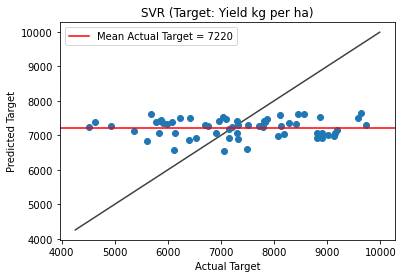

GBR
MAE on test data: 1269.4596108908604
RMSE on test data: 1594.1221036915588
R squared on test data: -0.5257716031034134
MAPE on test data: 18.669341519470663


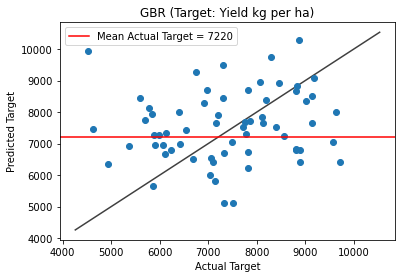

XGBoost
MAE on test data: 1160.7044640413374
RMSE on test data: 1460.2275983032516
R squared on test data: -0.2802284236529158
MAPE on test data: 17.21477079396076


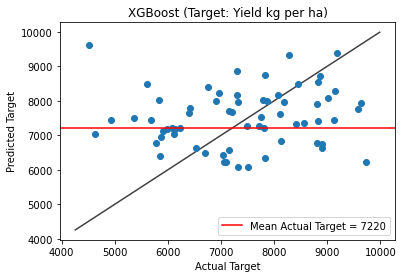

[20:22:17] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1047.9882268257834
RMSE on test data: 1289.0300338995787
R squared on test data: 0.0035929343633811506
MAPE on test data: 15.35818261691424


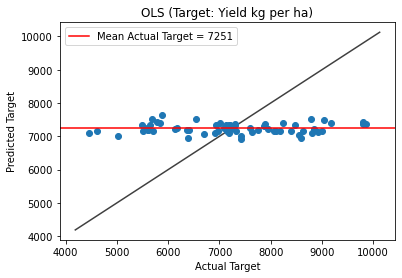

Lasso
MAE on test data: 1047.7559252812148
RMSE on test data: 1289.0996496129412
R squared on test data: 0.00348530698475058
MAPE on test data: 15.355288192311969


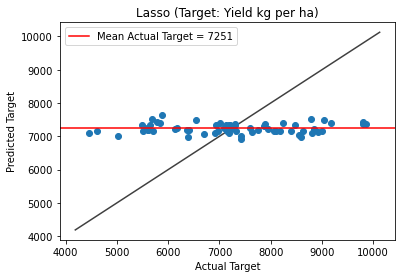

Ridge
MAE on test data: 1047.029566029198
RMSE on test data: 1288.971511293128
R squared on test data: 0.0036834070650695327
MAPE on test data: 15.345357594365227


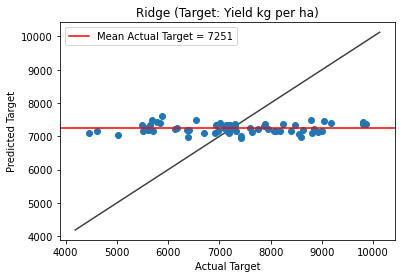

ElasticNet
MAE on test data: 1047.7849640947302
RMSE on test data: 1289.0906188623646
R squared on test data: 0.003499269045975417
MAPE on test data: 15.355650053098502


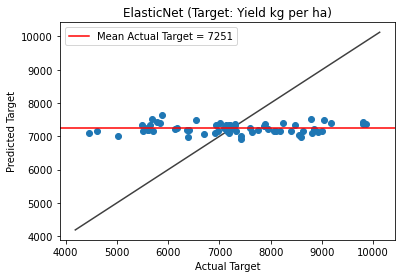

SVR
MAE on test data: 1083.259687152663
RMSE on test data: 1336.9197657247316
R squared on test data: -0.07181890786568634
MAPE on test data: 16.00713033809502


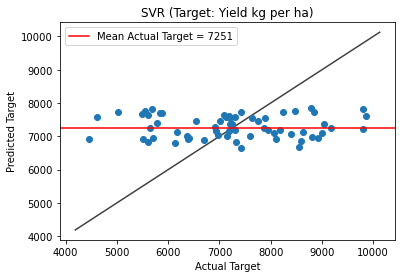

GBR
MAE on test data: 1323.7905364179828
RMSE on test data: 1599.735787404463
R squared on test data: -0.5346425896978528
MAPE on test data: 19.421996071475593


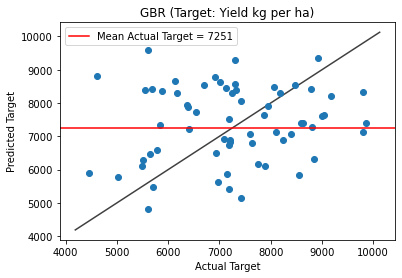

XGBoost
MAE on test data: 1242.9780870163972
RMSE on test data: 1480.4736854328714
R squared on test data: -0.31435327221575404
MAPE on test data: 18.148533512759542


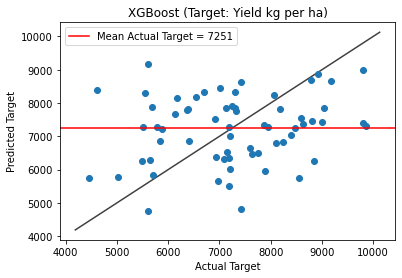

In [16]:
build_models(df_dy_wy_ratio_summer_combined_parents, 0, 50)
build_models(df_dy_wy_ratio_summer_combined_parents, 0, 60)
build_models(df_dy_wy_ratio_summer_combined_parents, 0, 70)
build_models(df_dy_wy_ratio_summer_combined_parents, 0, 80)
build_models(df_dy_wy_ratio_summer_combined_parents, .05, 50)
build_models(df_dy_wy_ratio_summer_combined_parents, .05, 60)
build_models(df_dy_wy_ratio_summer_combined_parents, .05, 70)
build_models(df_dy_wy_ratio_summer_combined_parents, .05, 80)
build_models(df_dy_wy_ratio_summer_combined_parents, .1, 50)
build_models(df_dy_wy_ratio_summer_combined_parents, .1, 60)
build_models(df_dy_wy_ratio_summer_combined_parents, .1, 70)
build_models(df_dy_wy_ratio_summer_combined_parents, .1, 80)

## Model Building Dataset 4: Winter Acceptable DY/WY Ratio Combined Parents

[20:22:40] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1363.4393655244417
RMSE on test data: 1709.8932643957446
R squared on test data: -0.0273270816063782
MAPE on test data: 24.481376068301078


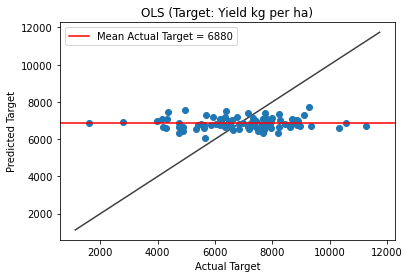

Lasso
MAE on test data: 1363.432888999492
RMSE on test data: 1709.7120245312299
R squared on test data: -0.027109310407168685
MAPE on test data: 24.48212624752167


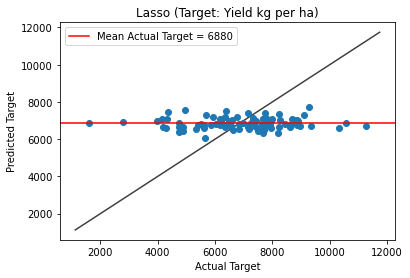

Ridge
MAE on test data: 1362.5280875504593
RMSE on test data: 1708.1946683783701
R squared on test data: -0.02528701631870911
MAPE on test data: 24.46970098343863


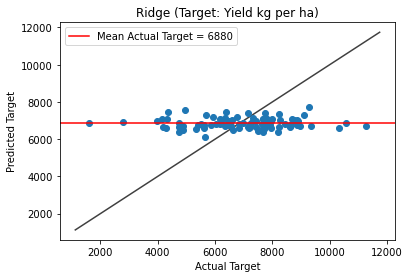

ElasticNet
MAE on test data: 1363.4336798631944
RMSE on test data: 1709.7342964119096
R squared on test data: -0.027136070241193577
MAPE on test data: 24.482032200837974


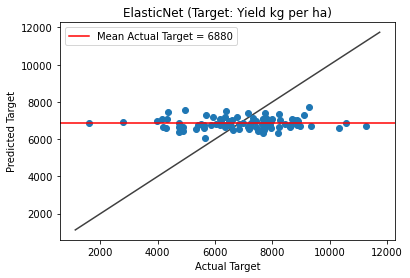

SVR
MAE on test data: 1342.512919134997
RMSE on test data: 1695.117791914949
R squared on test data: -0.009649183044847298
MAPE on test data: 24.135111972966282


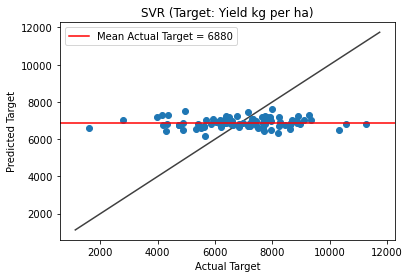

GBR
MAE on test data: 1408.9682191836341
RMSE on test data: 1847.6442238053905
R squared on test data: -0.1995198273599541
MAPE on test data: 24.240061082402146


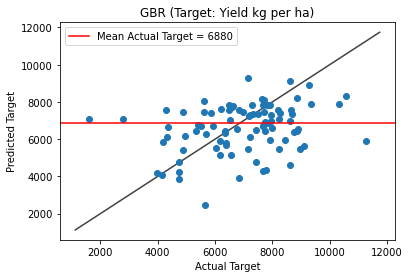

XGBoost
MAE on test data: 1387.4617857321311
RMSE on test data: 1766.3668664376462
R squared on test data: -0.09630792347624584
MAPE on test data: 23.86537136520804


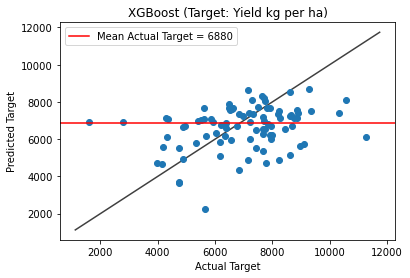

[20:23:03] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1573.4203258027749
RMSE on test data: 1867.1069058402227
R squared on test data: 0.00048534746788797545
MAPE on test data: 24.081426753508932


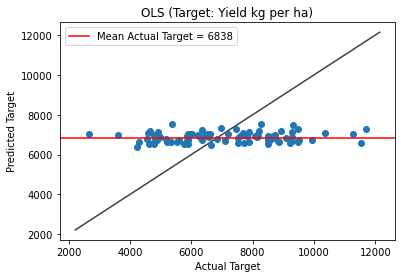

Lasso
MAE on test data: 1573.5290198899413
RMSE on test data: 1867.0549106562855
R squared on test data: 0.0005410156510159414
MAPE on test data: 24.084229820137438


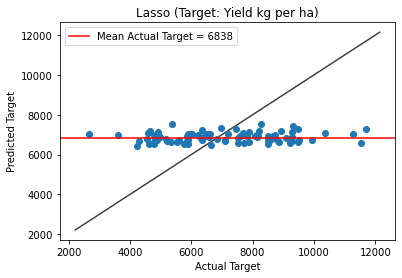

Ridge
MAE on test data: 1573.942586328887
RMSE on test data: 1867.0984965737246
R squared on test data: 0.0004943508796664275
MAPE on test data: 24.091445037128402


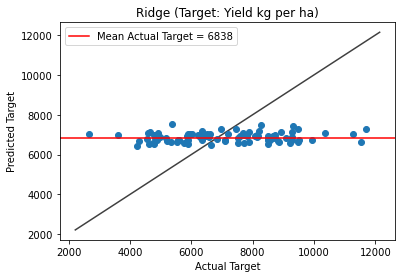

ElasticNet
MAE on test data: 1573.5022855519521
RMSE on test data: 1867.0581148749768
R squared on test data: 0.0005375851274802557
MAPE on test data: 24.083712894386558


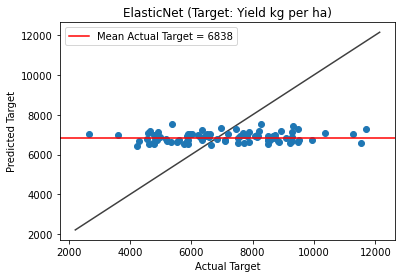

SVR
MAE on test data: 1550.1500348221482
RMSE on test data: 1860.2923570991438
R squared on test data: 0.007768070802549709
MAPE on test data: 23.938297909013404


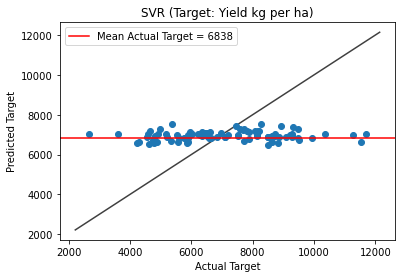

GBR
MAE on test data: 1612.979408391201
RMSE on test data: 1996.5635161815944
R squared on test data: -0.14292322052324025
MAPE on test data: 24.173663140566166


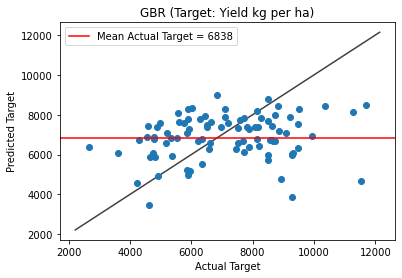

XGBoost
MAE on test data: 1511.0206975315252
RMSE on test data: 1855.3004592496281
R squared on test data: 0.013086025077008512
MAPE on test data: 22.41038789950679


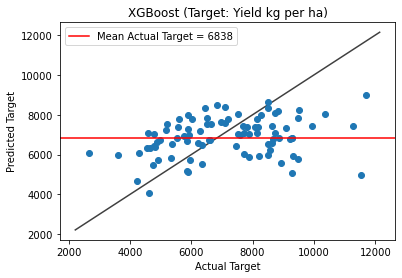

[20:23:26] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1123.5258846159104
RMSE on test data: 1381.4689448566878
R squared on test data: 0.001987774305027501
MAPE on test data: 18.315098524873076


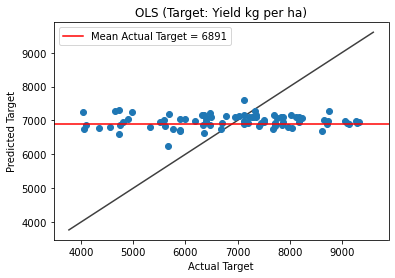

Lasso
MAE on test data: 1123.6577947669075
RMSE on test data: 1381.33901466336
R squared on test data: 0.002175495967459362
MAPE on test data: 18.31670875782628


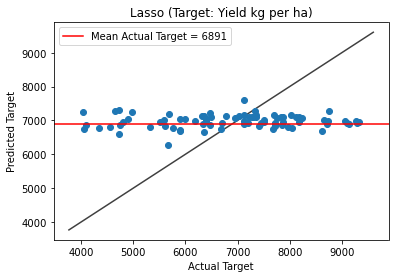

Ridge
MAE on test data: 1123.674260164715
RMSE on test data: 1380.5080966803291
R squared on test data: 0.0033755792892311565
MAPE on test data: 18.319010675982533


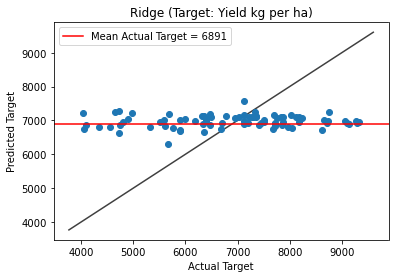

ElasticNet
MAE on test data: 1123.6413273321687
RMSE on test data: 1381.3549989553887
R squared on test data: 0.002152402996975944
MAPE on test data: 18.316507925049677


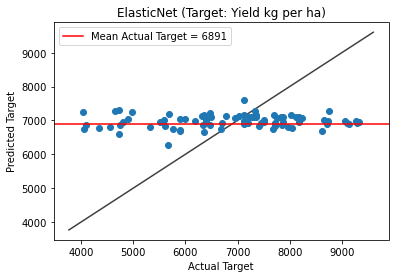

SVR
MAE on test data: 1112.2582844223223
RMSE on test data: 1378.4104028857257
R squared on test data: 0.006402036744837969
MAPE on test data: 18.114533825691556


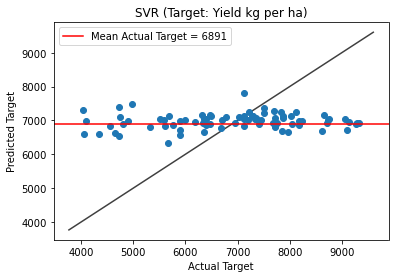

GBR
MAE on test data: 1258.7479246228777
RMSE on test data: 1552.3366857852711
R squared on test data: -0.2601593052131692
MAPE on test data: 18.99796359849064


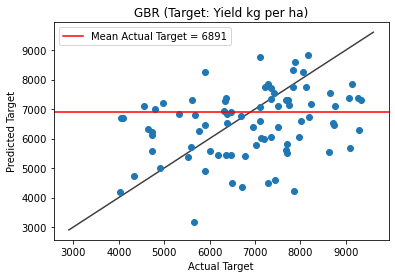

XGBoost
MAE on test data: 1093.8926413855613
RMSE on test data: 1357.9512285440678
R squared on test data: 0.035678270346205854
MAPE on test data: 16.747787889447586


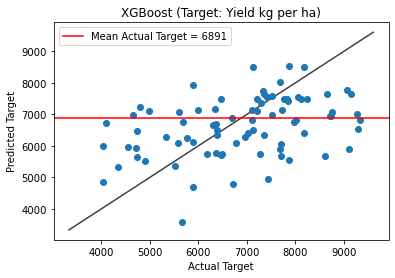

[20:23:48] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 1179.8103697656402
RMSE on test data: 1447.8161824063118
R squared on test data: -0.05508041122797991
MAPE on test data: 19.431456448495577


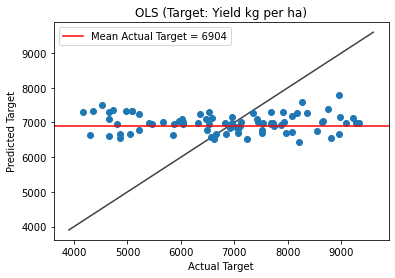

Lasso
MAE on test data: 1179.7920200876447
RMSE on test data: 1447.781200854214
R squared on test data: -0.055029426987108554
MAPE on test data: 19.431108394940097


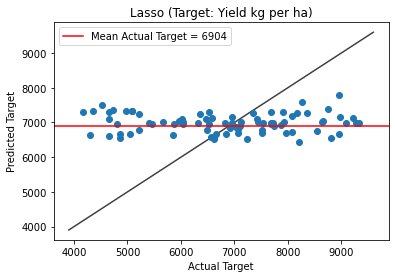

Ridge
MAE on test data: 1178.10316369315
RMSE on test data: 1444.0507052748126
R squared on test data: -0.04959944633988078
MAPE on test data: 19.395399898841294


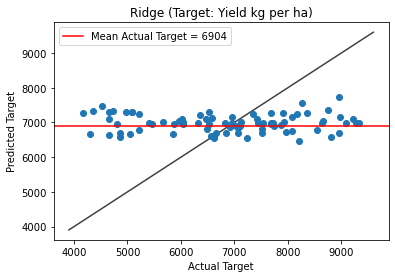

ElasticNet
MAE on test data: 1179.7802050069265
RMSE on test data: 1447.7584441802687
R squared on test data: -0.05499626068826724
MAPE on test data: 19.430882806659607


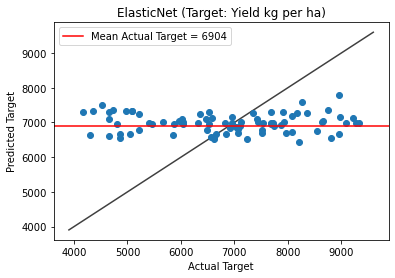

SVR
MAE on test data: 1164.6678174369536
RMSE on test data: 1439.6829281340752
R squared on test data: -0.04325966439456996
MAPE on test data: 19.11628497536716


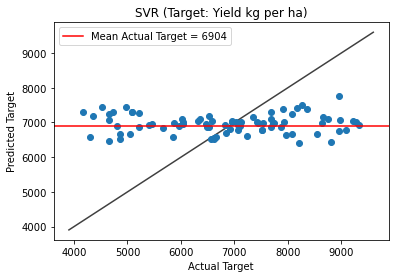

GBR
MAE on test data: 1229.4529000282494
RMSE on test data: 1582.7492997106876
R squared on test data: -0.260906742523743
MAPE on test data: 19.35637538078647


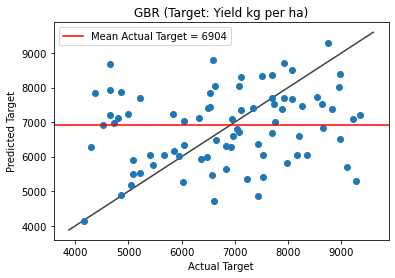

XGBoost
MAE on test data: 1174.5860808603911
RMSE on test data: 1499.07137416017
R squared on test data: -0.13110605993205549
MAPE on test data: 18.73253547551121


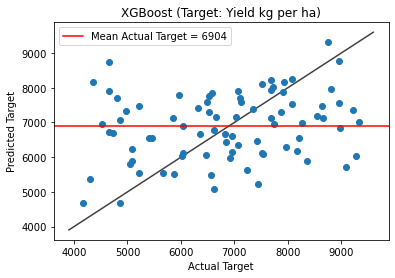

[20:24:10] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 947.0186284110262
RMSE on test data: 1154.7370500545373
R squared on test data: -0.04521919209443803
MAPE on test data: 15.197860007202879


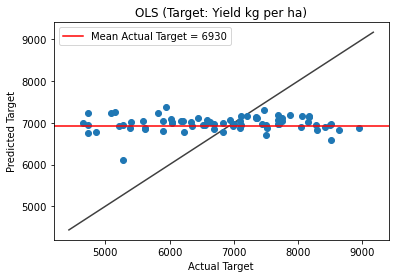

Lasso
MAE on test data: 947.0095025790591
RMSE on test data: 1154.3997292983465
R squared on test data: -0.044608624292138854
MAPE on test data: 15.198934685281198


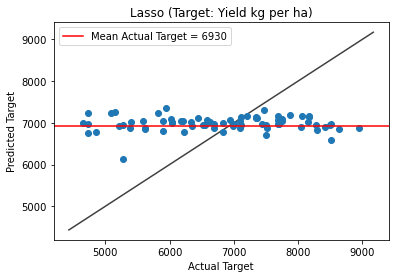

Ridge
MAE on test data: 947.2424087980113
RMSE on test data: 1153.2723349130797
R squared on test data: -0.04256927726173343
MAPE on test data: 15.208865906712388


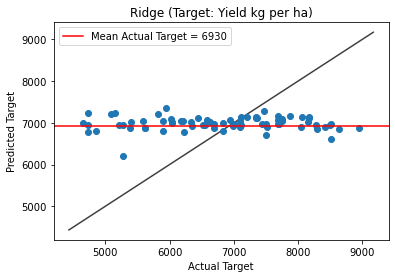

ElasticNet
MAE on test data: 947.0107172876451
RMSE on test data: 1154.4417007981895
R squared on test data: -0.04468458513417772
MAPE on test data: 15.19880148250847


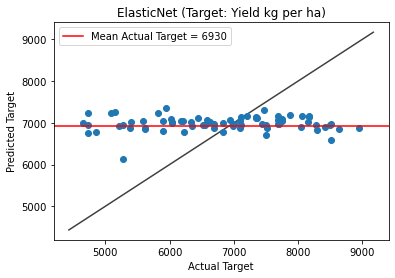

SVR
MAE on test data: 949.0897430895675
RMSE on test data: 1157.6624214872725
R squared on test data: -0.050521745509455984
MAPE on test data: 15.155908612861968


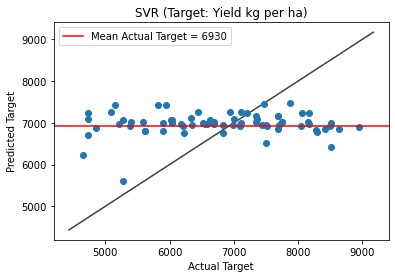

GBR
MAE on test data: 841.8221384859869
RMSE on test data: 1055.346557521898
R squared on test data: 0.12696557230970418
MAPE on test data: 13.146596820847744


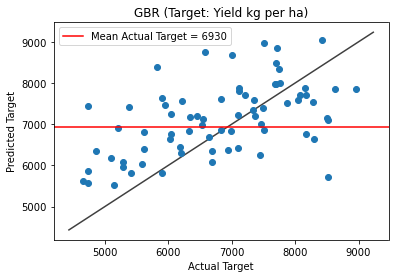

XGBoost
MAE on test data: 880.4204681202123
RMSE on test data: 1127.4947334135964
R squared on test data: 0.0035162556422175806
MAPE on test data: 13.903766030929374


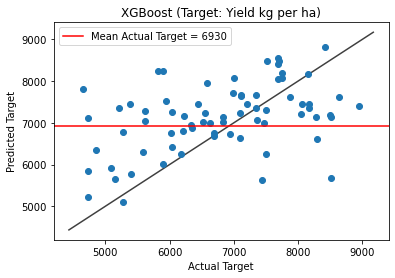

[20:24:31] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
OLS
MAE on test data: 897.998414185511
RMSE on test data: 1142.449127680503
R squared on test data: -0.07117736577004785
MAPE on test data: 13.885322180998646


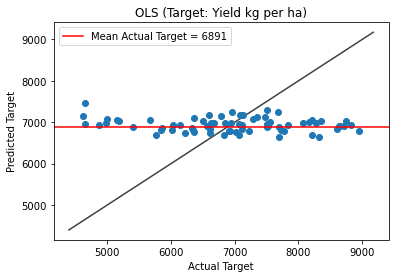

Lasso
MAE on test data: 897.9848759806566
RMSE on test data: 1142.425346971807
R squared on test data: -0.07113277193885015
MAPE on test data: 13.885150418251257


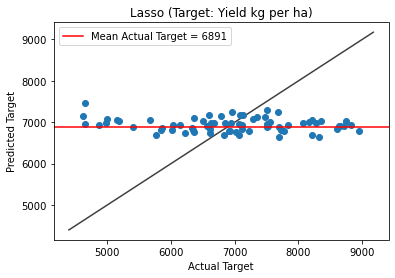

Ridge
MAE on test data: 895.8802199816154
RMSE on test data: 1139.262863333375
R squared on test data: -0.06521071972426351
MAPE on test data: 13.854925210622815


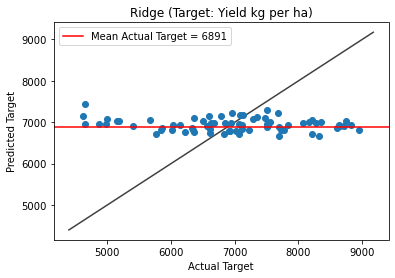

ElasticNet
MAE on test data: 897.9758309814697
RMSE on test data: 1142.4096977739164
R squared on test data: -0.07110342690733029
MAPE on test data: 13.885034147092368


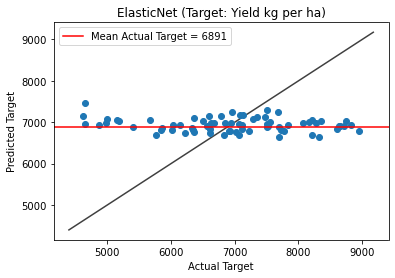

SVR
MAE on test data: 857.9870105177348
RMSE on test data: 1097.3613128998336
R squared on test data: 0.011704228937013839
MAPE on test data: 13.291844134887466


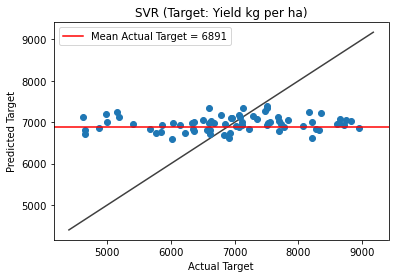

GBR
MAE on test data: 939.3778887937029
RMSE on test data: 1184.1778046970226
R squared on test data: -0.15085730854208945
MAPE on test data: 13.978038088024675


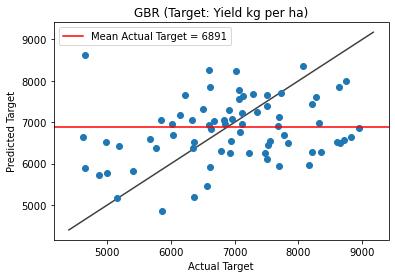

XGBoost
MAE on test data: 879.9556963410765
RMSE on test data: 1160.3451011144514
R squared on test data: -0.10499927388323416
MAPE on test data: 13.141059766317987


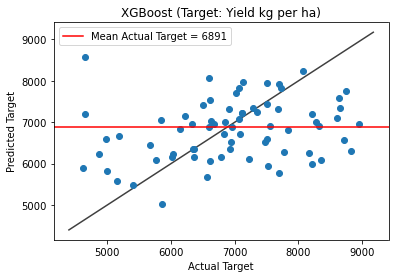

In [17]:
build_models(df_dy_wy_ratio_winter_combined_parents, 0, 50)
build_models(df_dy_wy_ratio_winter_combined_parents, 0, 60)
build_models(df_dy_wy_ratio_winter_combined_parents, 0, 70)
build_models(df_dy_wy_ratio_winter_combined_parents, 0, 80)
build_models(df_dy_wy_ratio_winter_combined_parents, .05, 50)
build_models(df_dy_wy_ratio_winter_combined_parents, .05, 60)
build_models(df_dy_wy_ratio_winter_combined_parents, .05, 70)
build_models(df_dy_wy_ratio_winter_combined_parents, .05, 80)
build_models(df_dy_wy_ratio_winter_combined_parents, .1, 50)
build_models(df_dy_wy_ratio_winter_combined_parents, .1, 60)
build_models(df_dy_wy_ratio_winter_combined_parents, .1, 70)
build_models(df_dy_wy_ratio_winter_combined_parents, .1, 80)